<h1 align='center'>Customer Churn Classification Project</h1>

## Business Objective:
There are three ways in which business increase their revenue stream and these are,
- Upsell to excisting customers
- Acquire new customers
- Increase customer retention

In this project we will focus on the third point which is customer churn prediction. Our goal is to build a machine learning model capable of predicting customers who will churn in the future so that the business can put in adequate measures to keep these customers in order to increase revenue.

### Data Understanding

The following describes the columns present in the data.

Gender -- Whether the customer is a male or a female

SeniorCitizen -- Whether a customer is a senior citizen or not

Partner -- Whether the customer has a partner or not (Yes, No)

Dependents -- Whether the customer has dependents or not (Yes, No)

Tenure -- Number of months the customer has stayed with the company

Phone Service -- Whether the customer has a phone service or not (Yes, No)

MultipleLines -- Whether the customer has multiple lines or not

InternetService -- Customer's internet service provider (DSL, Fiber Optic, No)

OnlineSecurity -- Whether the customer has online security or not (Yes, No, No Internet)

OnlineBackup -- Whether the customer has online backup or not (Yes, No, No Internet)

DeviceProtection -- Whether the customer has device protection or not (Yes, No, No internet service)

TechSupport -- Whether the customer has tech support or not (Yes, No, No internet)

StreamingTV -- Whether the customer has streaming TV or not (Yes, No, No internet service)

StreamingMovies -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

Contract -- The contract term of the customer (Month-to-Month, One year, Two year)

PaperlessBilling -- Whether the customer has paperless billing or not (Yes, No)

Payment Method -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))

MonthlyCharges -- The amount charged to the customer monthly

TotalCharges -- The total amount charged to the customer

Churn -- Whether the customer churned or not (Yes or No)

#### The details presented above can further be grouped into the following:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, and if they have partners and dependents

### Import necessary Libraries

In [353]:
# Data Manipulation and Connection
import numpy as np
import pandas as pd
import pyodbc
from dotenv import dotenv_values

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# Machine Learning and Preprocessing
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Other Utilities
from warnings import filterwarnings
filterwarnings('ignore')

### Load Datasets

In [354]:
# Load Environment Variables
config = dotenv_values('.env')

Server_name = config.get('Server')
Database_name = config.get('Database')
Username = config.get('Login')
PassWord = config.get('Password')

# Create Database Connection
connection_string = f"DRIVER={{SQL Server}};SERVER={Server_name};DATABASE={Database_name};UID={Username};PWD={PassWord}"

connection = pyodbc.connect(connection_string)

In [355]:
query = 'SELECT * FROM dbo.LP2_Telco_churn_first_3000'
model_df1 = pd.read_sql(query, connection)
model_df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [356]:
model_df1.shape

(3000, 21)

In [357]:
# Load dataset from GitHub
model_df2 = pd.read_csv('https://raw.githubusercontent.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-second-2000.csv')
model_df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [358]:
model_df2.shape

(2043, 21)

In [359]:
# Concatinate model dataframe
full_model_df = pd.concat([model_df1, model_df2], ignore_index=True)
f'There are {full_model_df.shape[0]} rows and {full_model_df.shape[1]} columns in the dataset.'

'There are 5043 rows and 21 columns in the dataset.'

In [360]:
# Load Excel file
test_df = pd.read_excel('Telco-churn-second-2000.xlsx')
test_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [361]:
test_df['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

## Hypothesis

### Null Hypothesis: There is not a signigicant association between churned customers and use of TechSupport.

### Alternate Hypothesis: There is a signigicant association between churned customers and use of TechSupport.

## Questions

1. How many male customers with dependents churned over the various payment methods?
2. How many female customers with dependents churned over the various payment methods?
3. What is the distribution of male and female customers who churned given their multiplines status?
4. What percentage of monthly charges was accumulated given the customer gender?
5. What percentage of monthly charges was accumulated given the customer churn status?

## Exploratory Data Analysis (EDA)

In [362]:
# Check the structure of the dataset
full_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


We are able to see the data type, and the number of non-null values for each column in the data set. Total Charges column is currently an object and must be converted to a float.

In [363]:
# Check for missing values
full_model_df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [364]:
# Check the percentage of missing values for each column
(full_model_df.isnull().sum()/len(full_model_df))*100

customerID           0.000000
gender               0.000000
SeniorCitizen        0.000000
Partner              0.000000
Dependents           0.000000
tenure               0.000000
PhoneService         0.000000
MultipleLines        5.334127
InternetService      0.000000
OnlineSecurity      12.908983
OnlineBackup        12.908983
DeviceProtection    12.908983
TechSupport         12.908983
StreamingTV         12.908983
StreamingMovies     12.908983
Contract             0.000000
PaperlessBilling     0.000000
PaymentMethod        0.000000
MonthlyCharges       0.000000
TotalCharges         0.099147
Churn                0.019829
dtype: float64

- Considering the percentage of missing values in the MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies columns we will have to fill the missing values.

In [365]:
# Check for duplicates in the dataset
f'There are {full_model_df.duplicated().sum()} duplicate columns in the dataset.'

'There are 0 duplicate columns in the dataset.'

In [366]:
# Check the number of unique values in each column
full_model_df.nunique()

customerID          5043
gender                 2
SeniorCitizen          2
Partner                4
Dependents             4
tenure                73
PhoneService           4
MultipleLines          5
InternetService        3
OnlineSecurity         5
OnlineBackup           5
DeviceProtection       5
TechSupport            5
StreamingTV            5
StreamingMovies        5
Contract               3
PaperlessBilling       4
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4884
Churn                  4
dtype: int64

- We view the number of unique values in all the columns in the dataset.

In [367]:
# View the unique values in the gender column
full_model_df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [368]:
# View the unique values in the SeniorCitizen column
full_model_df['SeniorCitizen'].unique()

array([False, True], dtype=object)

In [369]:
full_model_df['SeniorCitizen'].tail()

5038    0
5039    0
5040    0
5041    1
5042    0
Name: SeniorCitizen, dtype: object

In [370]:
full_model_df['SeniorCitizen'].head()

0    False
1    False
2    False
3    False
4    False
Name: SeniorCitizen, dtype: object

#### The seniorCitizen columns have True and False values which we will have to correct to 0's and 1's.

In [371]:
full_model_df['SeniorCitizen'] = full_model_df['SeniorCitizen'].replace({False:0, True:1}, inplace=True)

In [372]:
# View the unique values in the Partner column
full_model_df['Partner'].unique()

array([True, False, 'No', 'Yes'], dtype=object)

In [373]:
# View the unique values in the Dependents column
full_model_df['Dependents'].unique()

array([False, True, 'No', 'Yes'], dtype=object)

In [374]:
# View the unique values in the tenure column
full_model_df['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

In [375]:
# View the unique values in the PhoneService column
full_model_df['PhoneService'].unique()

array([False, True, 'Yes', 'No'], dtype=object)

In [376]:
# View the unique values in the MultipleLines column
full_model_df['MultipleLines'].unique()

array([None, False, True, 'No', 'No phone service', 'Yes'], dtype=object)

In [377]:
# View the unique values in the InternetService column
full_model_df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [378]:
# View the unique values in the OnlineSecurity column
full_model_df['OnlineSecurity'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [379]:
# View the unique values in the OnlineBackup column
full_model_df['OnlineBackup'].unique()

array([True, False, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [380]:
# View the unique values in the DeviceProtection column
full_model_df['DeviceProtection'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [381]:
# View the unique values in the TechSupport column
full_model_df['TechSupport'].unique()

array([False, True, None, 'Yes', 'No', 'No internet service'],
      dtype=object)

In [382]:
# View the unique values in the StreamingTV column
full_model_df['StreamingTV'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [383]:
# View the unique values in the StreamingMovies column
full_model_df['StreamingMovies'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [384]:
# View the unique values in the Contract column
full_model_df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [385]:
# View the unique values in the PaperlessBilling column
full_model_df['PaperlessBilling'].unique()

array([True, False, 'Yes', 'No'], dtype=object)

In [386]:
# View the unique values in the PaymentMethod column
full_model_df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [387]:
# View the unique values in the TotalCharges column
full_model_df['TotalCharges'].unique()

array([29.850000381469727, 1889.5, 108.1500015258789, ..., '346.45',
       '306.6', '6844.5'], dtype=object)

In [388]:
full_model_df[full_model_df['TotalCharges']==' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3218,2923-ARZLG,Male,None,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
4670,4075-WKNIU,Female,None,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No
4754,2775-SEFEE,Male,None,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No


#### - The total charges column have values which have been converted to a string which must be cast back in to a float.
#### - Three rows in the dataset have empty string as an amount for the total charges value and this must be corrected corrected to NA.

In [389]:
# View the unique values in the Churn column
full_model_df['Churn'].unique()

array([False, True, None, 'No', 'Yes'], dtype=object)

In [390]:
# Drop row with missing value in the churn column
full_model_df.dropna(subset='Churn', inplace=True)

#### True and False values in every column in the dataset must be changed to Yes and No to ensure uniformity in the columns.

In [391]:
# Create a function to convert True and False values to Yes and No respectively.
def value_cleaner(data):
    for column in data.columns:
        if np.any(data[column].isin(['Yes', 'No'])):
            data[column] = data[column].replace({True:'Yes', False:'No'})
    return data

In [392]:
full_model_df = value_cleaner(full_model_df)
full_model_df.nunique()

customerID          5042
gender                 2
SeniorCitizen          0
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4883
Churn                  2
dtype: int64

In [393]:
full_model_df['SeniorCitizen'].unique()

array([None], dtype=object)

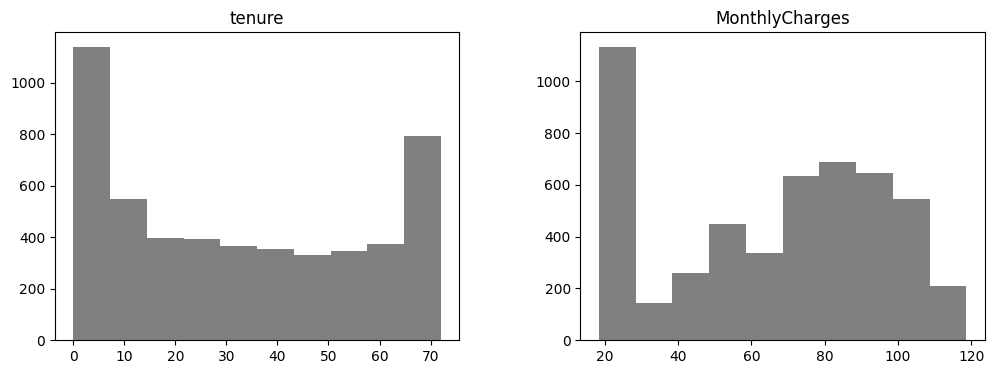

In [394]:
# Check the distrubion of the numerical columns in the datset
full_model_df.hist(figsize=(12, 4), grid=False, color='grey');

#### Observation


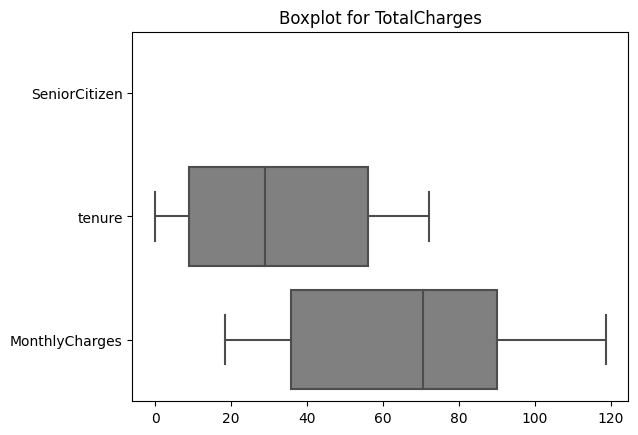

In [395]:
sns.boxplot(full_model_df, orient='horizontal', color='grey')
plt.title('Boxplot for TotalCharges')
plt.show()

#### Observation


- The values in the MonthlyCharges column are approximately normally distributed

### Univariate Analysis

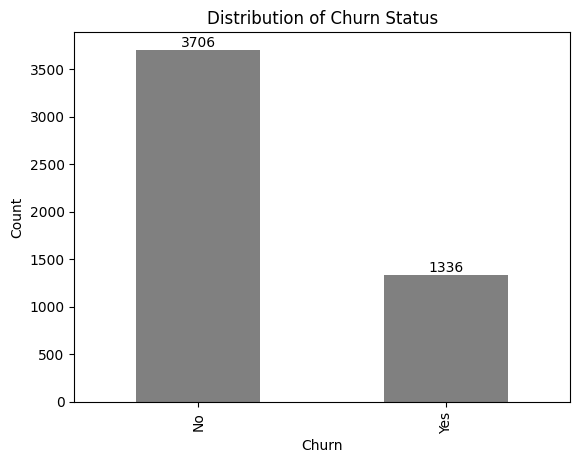

In [396]:
churn_count = full_model_df['Churn'].value_counts()
ax = churn_count.plot(kind='bar', color='grey')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Churn Status')
plt.ylabel('Count')
plt.show()

#### Observation
- The outcome value is inbalanced since more customers have been indicated not to have churned compared to customers who churned.

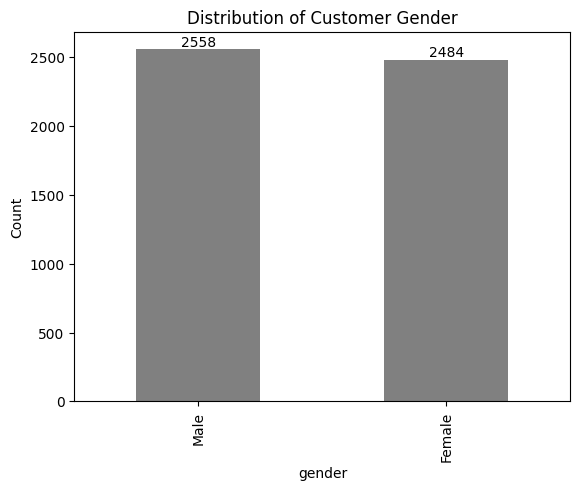

In [397]:
gender_count = full_model_df['gender'].value_counts()
ax = gender_count.plot(kind='bar', color='grey')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer Gender')
plt.ylabel('Count')
plt.show()

#### Observation

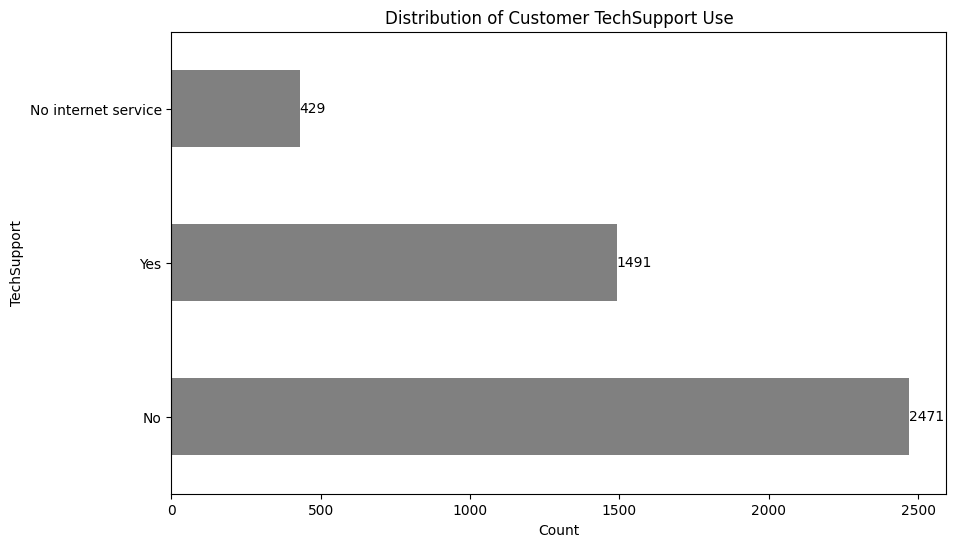

In [398]:
techsupport_count = full_model_df['TechSupport'].value_counts()
plt.figure(figsize=(10, 6))
ax = techsupport_count.plot(kind='barh', color='grey')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer TechSupport Use')
plt.xlabel('Count')
plt.show()

#### Observation

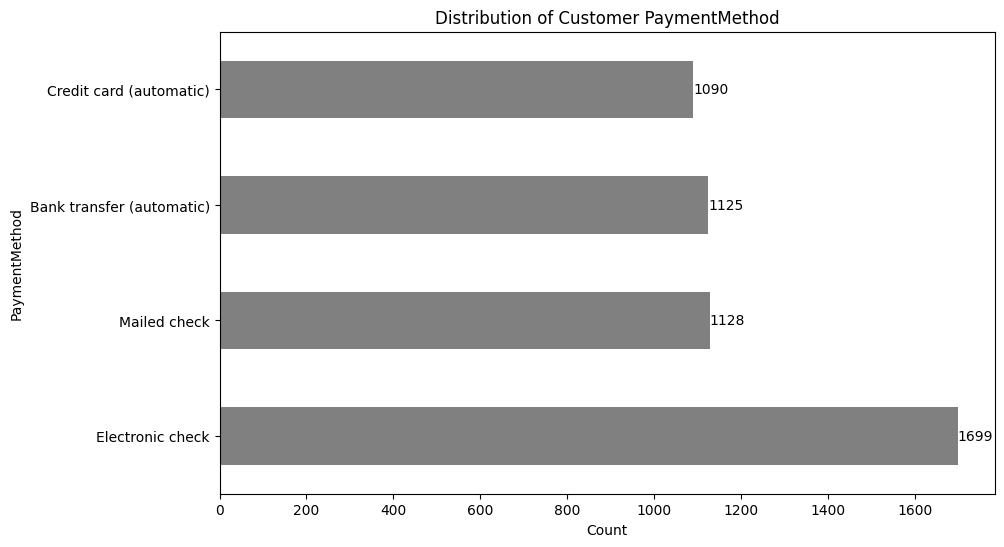

In [399]:
paymentmethod_count = full_model_df['PaymentMethod'].value_counts()
plt.figure(figsize=(10, 6))
ax = paymentmethod_count.plot(kind='barh', color='grey')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer PaymentMethod')
plt.xlabel('Count')
plt.show()

#### Observation

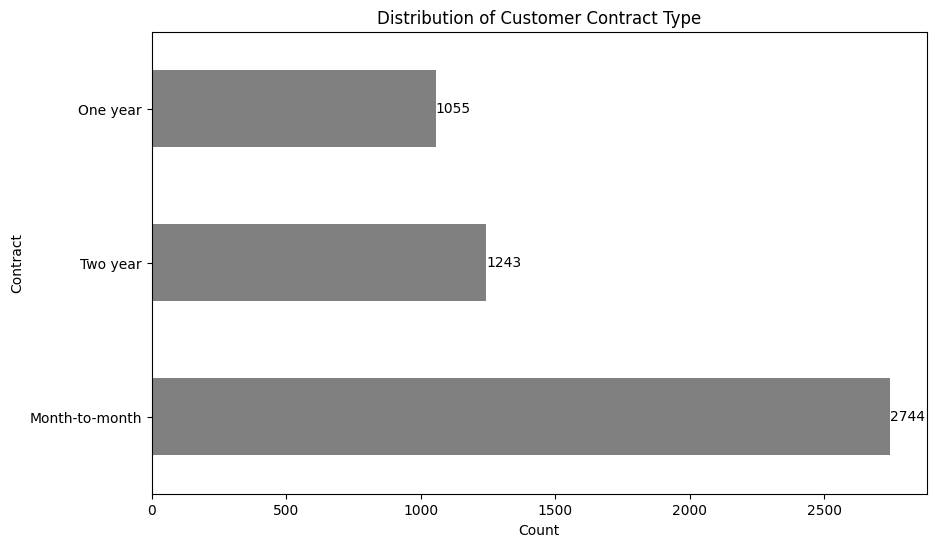

In [400]:
contract_count = full_model_df['Contract'].value_counts()
plt.figure(figsize=(10, 6))
ax = contract_count.plot(kind='barh',color='grey')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer Contract Type')
plt.xlabel('Count')
plt.show()

#### Observation

### Bivariate & Multivariate Analysis

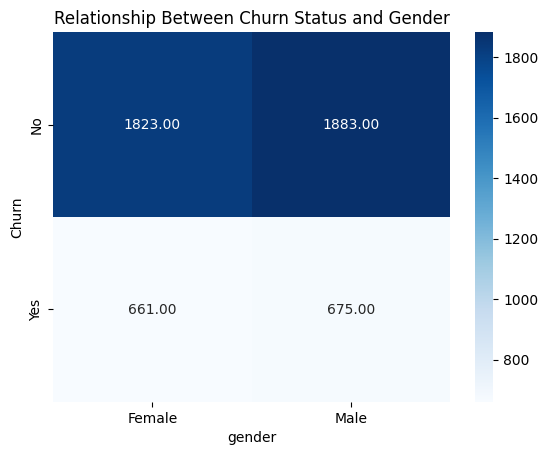

In [401]:
sns.heatmap(pd.crosstab(full_model_df['Churn'],full_model_df['gender']), cmap='Blues', annot=True,fmt='.2f')
plt.title('Relationship Between Churn Status and Gender')
plt.show()

#### Observation

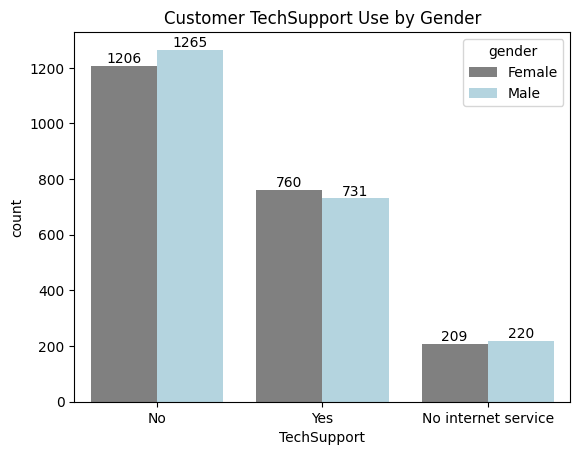

In [402]:
ax=sns.countplot(data=full_model_df, x='TechSupport', hue='gender', palette=['grey','lightblue'])
for bar in ax.containers:
    ax.bar_label(bar)
plt.title('Customer TechSupport Use by Gender')
plt.show()

#### Observation

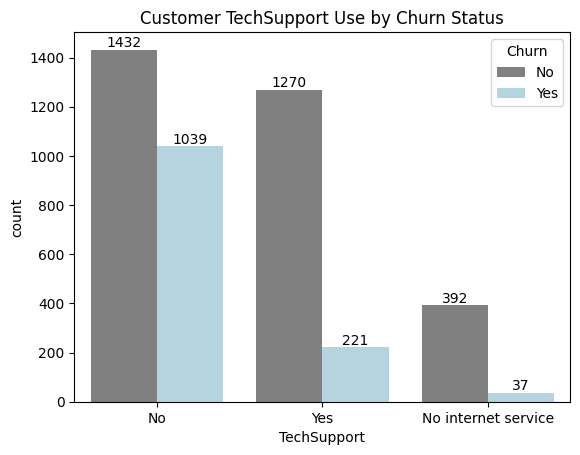

In [403]:
ax=sns.countplot(data=full_model_df, x='TechSupport', hue='Churn', palette=['grey','lightblue'])
for bar in ax.containers:
    ax.bar_label(bar)
plt.title('Customer TechSupport Use by Churn Status')
plt.show()

#### Observation

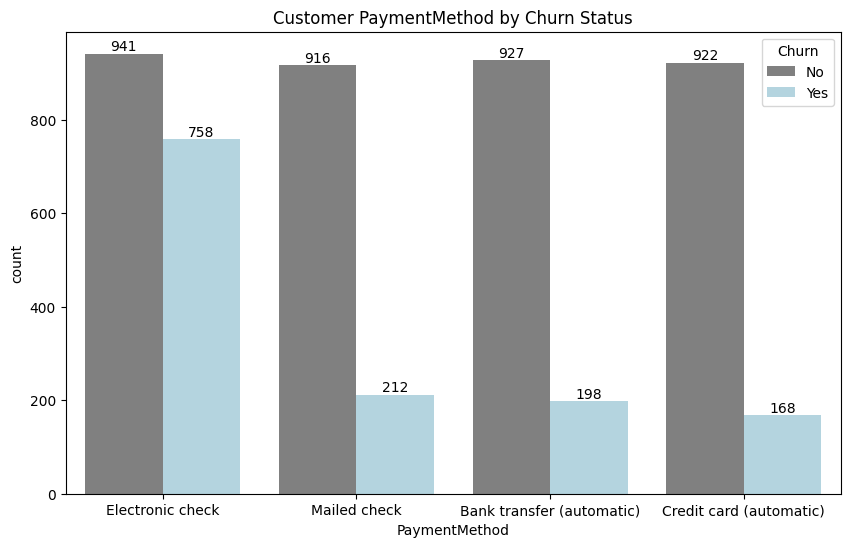

In [404]:
plt.figure(figsize=(10, 6))
ax=sns.countplot(data=full_model_df, x='PaymentMethod', hue='Churn', palette=['grey','lightblue'])
for bar in ax.containers:
    ax.bar_label(bar)
plt.title('Customer PaymentMethod by Churn Status')
plt.show()

#### Observations

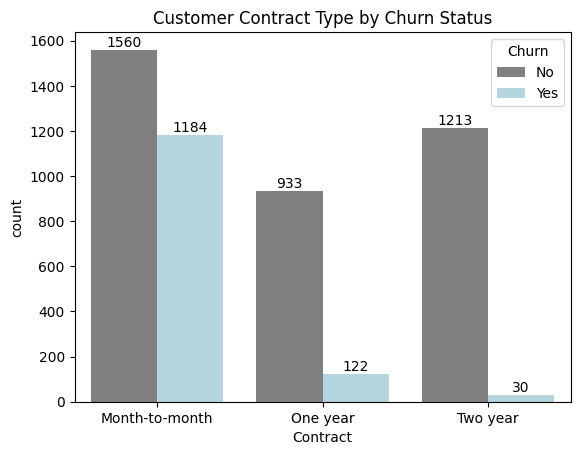

In [405]:
ax=sns.countplot(data=full_model_df, x='Contract', hue='Churn', palette=['grey','lightblue'])
for bar in ax.containers:
    ax.bar_label(bar)
plt.title('Customer Contract Type by Churn Status')
plt.show()

#### Observations

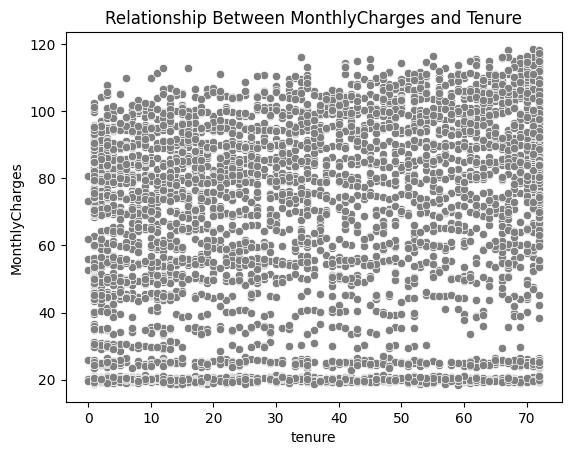

In [406]:
sns.scatterplot(full_model_df, x='tenure',y='MonthlyCharges', color='grey')
plt.title('Relationship Between MonthlyCharges and Tenure')
plt.show()

#### Observations

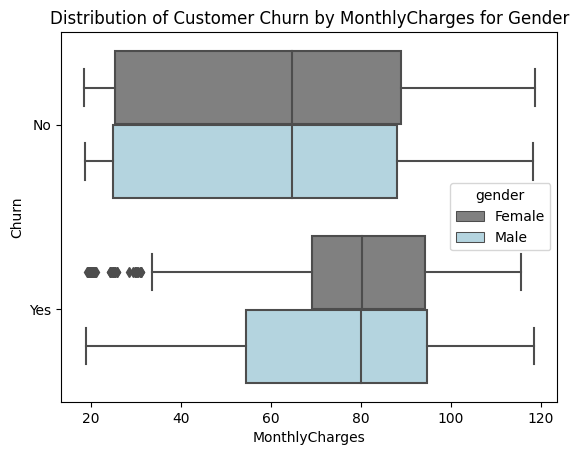

In [407]:
sns.boxplot(full_model_df, x='MonthlyCharges', y='Churn', hue='gender', palette=['grey','lightblue'])
plt.title('Distribution of Customer Churn by MonthlyCharges for Gender')
plt.show()

#### Observation

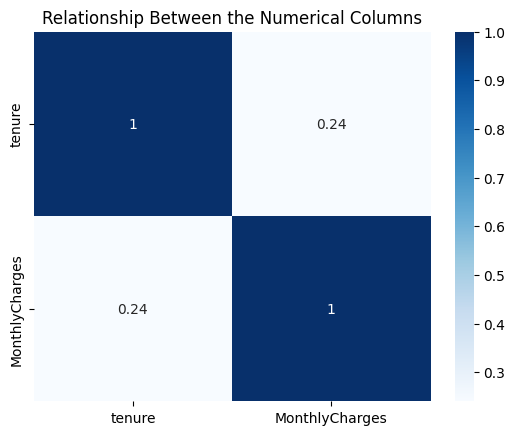

In [408]:
num_columns = full_model_df.select_dtypes('number')
correlation = num_columns.corr()
sns.heatmap(correlation, cmap='Blues', annot=True)
plt.title('Relationship Between the Numerical Columns')
plt.show()

#### Observations

## Answering Analytical Questions

#### 1. How many male customers with dependents churned over the various payment methods?

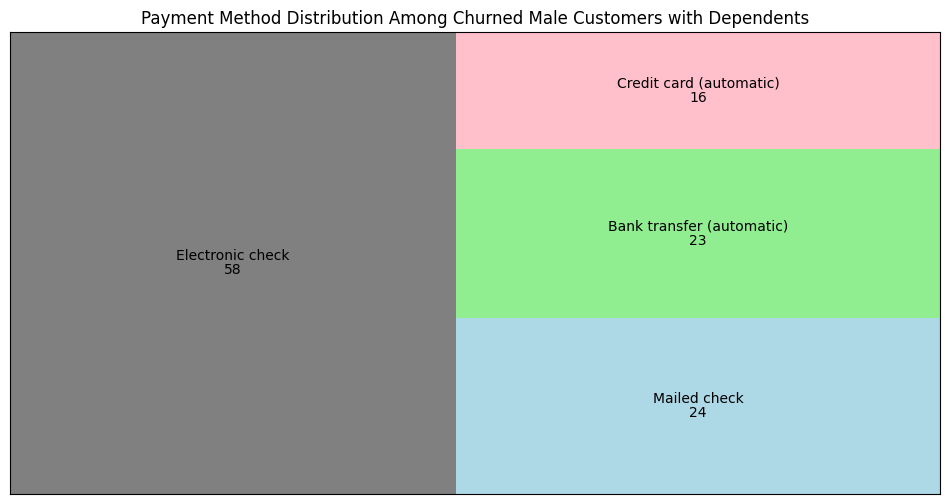

In [409]:
mal_churned_customers = full_model_df[(full_model_df['gender']=='Male') & (full_model_df['Dependents']=='Yes') & (full_model_df['Churn']=='Yes')]['PaymentMethod'].value_counts()

values = mal_churned_customers.unique()
labels = mal_churned_customers.index
colors = ['grey', 'lightblue', 'lightgreen', 'pink']

plt.figure(figsize=(12, 6))
squarify.plot(mal_churned_customers,label=labels, value=values, color=colors)
plt.title('Payment Method Distribution Among Churned Male Customers with Dependents')
plt.xticks([])
plt.yticks([])
plt.show()



#### Observation


#### 2. How many female customers with dependents churned over the various payment methods?

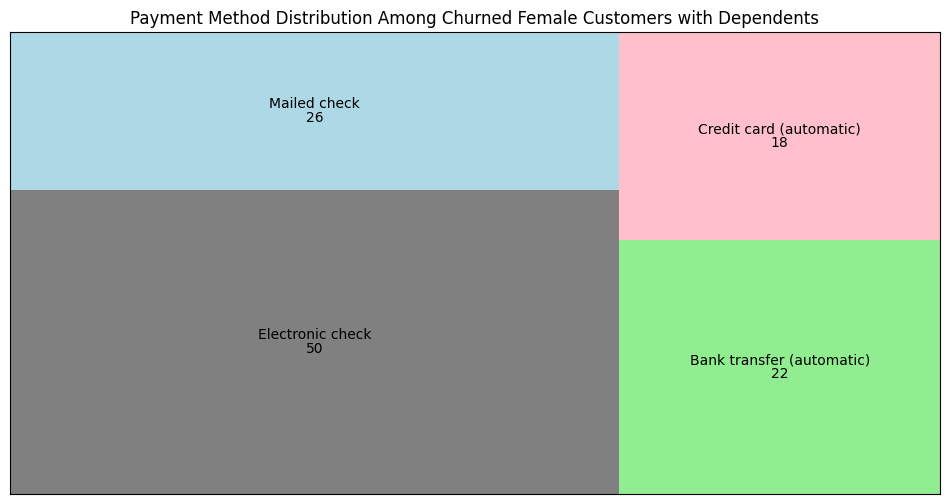

In [410]:
fem_churned_customers = full_model_df[(full_model_df['gender']=='Female') & (full_model_df['Dependents']=='Yes') & (full_model_df['Churn']=='Yes')]['PaymentMethod'].value_counts()

values = fem_churned_customers.unique()
labels = fem_churned_customers.index
colors = ['grey', 'lightblue', 'lightgreen', 'pink']

plt.figure(figsize=(12, 6))
squarify.plot(fem_churned_customers,label=labels, value=values, color=colors)
plt.title('Payment Method Distribution Among Churned Female Customers with Dependents')
plt.xticks([])
plt.yticks([])
plt.show()

#### Observation


#### 3. What is the distribution of male and female customers who churned given their multiplines status?

Text(0.5, 1.0, 'Distribution of Churned Customers with MultipleLines by Gender')

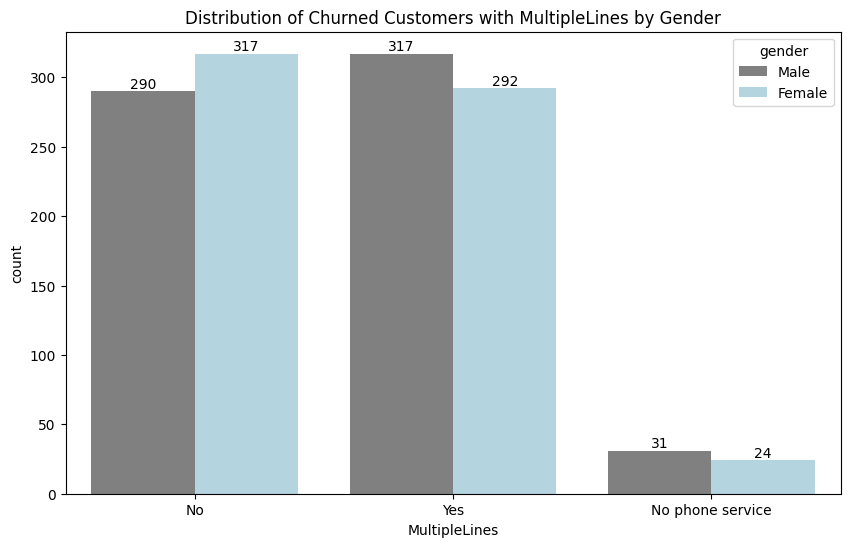

In [411]:
churned = full_model_df[full_model_df['Churn']=='Yes']
plt.figure(figsize=(10, 6))
ax=sns.countplot(churned, x='MultipleLines', hue='gender', palette=['grey', 'lightblue'])
for bar in ax.containers:
    ax.bar_label(bar)
plt.title('Distribution of Churned Customers with MultipleLines by Gender')

#### Observation

#### 4. What percentage of monthly charges was accumulated given the customer gender?

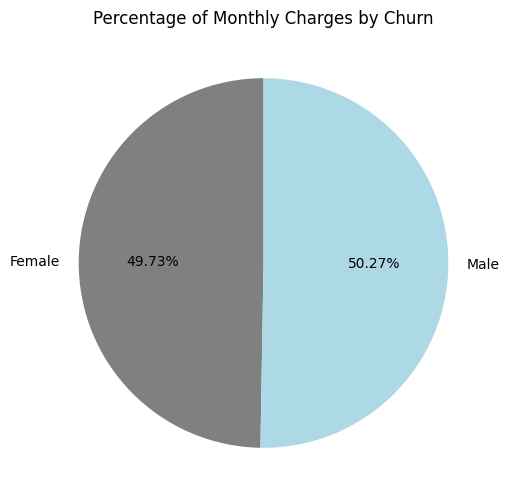

In [412]:
monthly_charges = full_model_df.groupby('gender')['MonthlyCharges'].sum()
plt.figure(figsize=(6,6))
plt.pie(monthly_charges, startangle=90, autopct='%1.2f%%',colors=['grey', 'lightblue'],labels=monthly_charges.index)
plt.title('Percentage of Monthly Charges by Churn')
plt.show()

#### Observation

#### 5. What percentage of monthly charges was accumulated given the customer churn status?

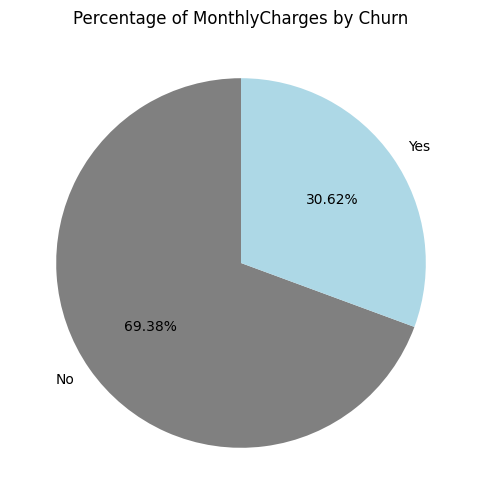

In [413]:
monthly_charges = full_model_df.groupby('Churn')['MonthlyCharges'].sum()
plt.figure(figsize=(6,6))
plt.pie(monthly_charges, startangle=90, autopct='%1.2f%%',colors=['grey', 'lightblue'],labels=monthly_charges.index)
plt.title('Percentage of MonthlyCharges by Churn')
plt.show()

#### Observation

## Feature Processing and Engineering

### Split dataset into test and evaluation

In [414]:
X = full_model_df.drop(columns='Churn', axis=1)
y = full_model_df['Churn']

In [415]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Pipelines

In [416]:
class columnDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(['customerID'], axis=1)


    
class TotalCharges_cleaner(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Replace empty string with NA
        X['TotalCharges'].replace(' ', np.nan, inplace=True)

        # Convert the values in the Totalcharges column to a float
        X['TotalCharges'] = X['TotalCharges'].transform(lambda x: float(x))
        return X



In [417]:
num_columns = ['SeniorCitizen','tenure', 'MonthlyCharges', 'TotalCharges']
cat_columns = ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod']

cat_pipeline = Pipeline([
        ('column_dropper', columnDropper()),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder', OneHotEncoder(sparse=False)),
])

num_pipeline = Pipeline([
        ('total_charges_cleaner', TotalCharges_cleaner()),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="mean")),
        ('pt_transform', PowerTransformer()),
        ('scaling', StandardScaler()),
])

full_pipeline = ColumnTransformer([    
    ('num_pipeline', num_pipeline, num_columns),
    ('cat_pipeline', cat_pipeline, cat_columns),
])


y_train_encoded = y_train.replace({'Yes':1, 'No':0})
y_eval_encoded = y_eval.replace({'Yes':1, 'No':0})

### Machine Learning Pipeline

#### RandomForest Classifier Pipeline

In [418]:
randomForest_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', RandomForestClassifier())
])

randomForest_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', RandomForestClassifier())])

In [419]:
rfc_y_pred = randomForest_pipeline.predict(X_eval)
rfc_report = classification_report(y_eval_encoded, rfc_y_pred)

# Define model predictions for the model and true labels
rfc_pred_proba = randomForest_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
rfc_fpr, rfc_tpr, _ = roc_curve(y_eval_encoded, rfc_pred_proba)
# Calculate AUC for the model
rfc_auc_score = auc(rfc_fpr, rfc_tpr)

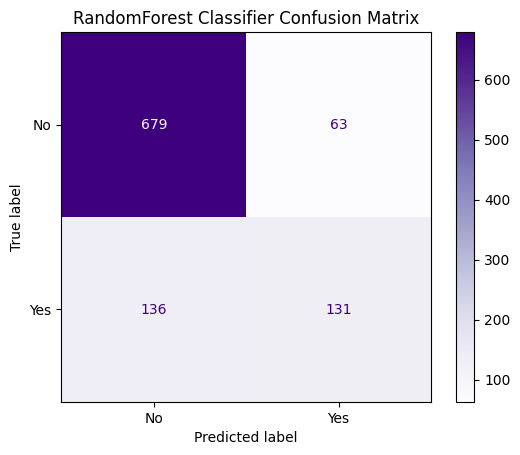

In [420]:
rfc_cnf_matrix = confusion_matrix(y_eval_encoded, rfc_y_pred)
disp = ConfusionMatrixDisplay(rfc_cnf_matrix, display_labels=['No', 'Yes'])
disp.plot(cmap='Purples')
plt.title('RandomForest Classifier Confusion Matrix');

#### DecisionTree Classifier Pipeline

In [421]:
decisionTree_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

decisionTree_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [422]:
dtc_y_pred = decisionTree_pipeline.predict(X_eval)
dtc_report = classification_report(y_eval_encoded, dtc_y_pred)

# Define model predictions for the model and true labels
dtc_pred_proba = decisionTree_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
dtc_fpr, dtc_tpr, _ = roc_curve(y_eval_encoded, dtc_pred_proba)
# Calculate AUC for the model
dtc_auc_score = auc(dtc_fpr, dtc_tpr)

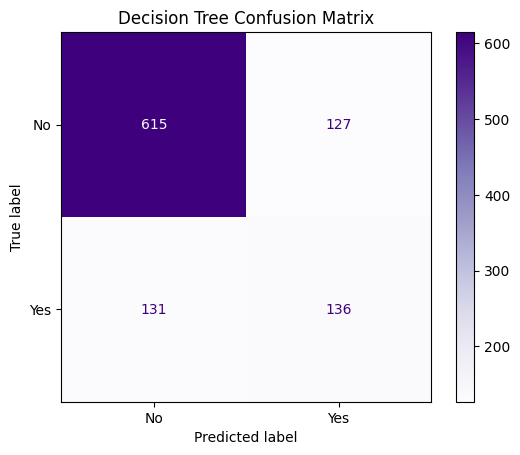

In [423]:
dtc_cnf_matrix = confusion_matrix(y_eval_encoded, dtc_y_pred)
disp = ConfusionMatrixDisplay(dtc_cnf_matrix,display_labels=['No', 'Yes'])
disp.plot(cmap='Purples')
plt.title('Decision Tree Confusion Matrix');

#### Gradient Boosting Classifier Pipeline

In [424]:
gradientBoosting_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', GradientBoostingClassifier(random_state=0))
])

gradientBoosting_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', GradientBoostingClassifier(random_state=0))])

In [425]:
gbc_y_pred = gradientBoosting_pipeline.predict(X_eval)
gbc_report = classification_report(y_eval_encoded, gbc_y_pred)

# Define model predictions for the model and true labels
gbc_pred_proba = gradientBoosting_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
gbc_fpr, gbc_tpr, _ = roc_curve(y_eval_encoded, gbc_pred_proba)
# Calculate AUC for the model
gbc_auc_score = auc(gbc_fpr, gbc_tpr)

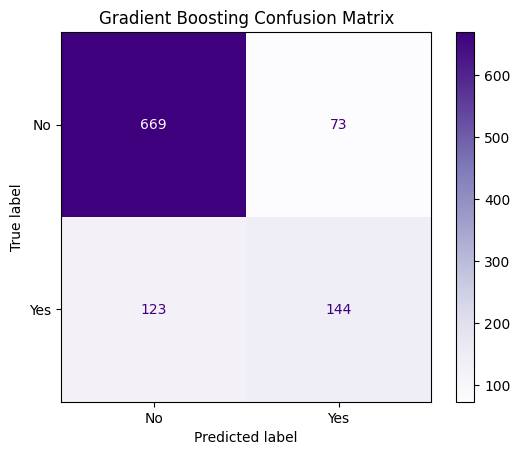

In [426]:
gbc_cnf_matrix = confusion_matrix(y_eval_encoded, gbc_y_pred)
disp = ConfusionMatrixDisplay(gbc_cnf_matrix,display_labels=['No', 'Yes'])
disp.plot(cmap='Purples')
plt.title('Gradient Boosting Confusion Matrix');

#### KNN Classifier Pipeline

In [427]:
KNN_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', KNeighborsClassifier())
])

KNN_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', KNeighborsClassifier())])

In [428]:
knn_y_pred = KNN_pipeline.predict(X_eval)
knn_report = classification_report(y_eval_encoded, knn_y_pred)

# Define model predictions for the model and true labels
knn_pred_proba = KNN_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
knn_fpr, knn_tpr, _ = roc_curve(y_eval_encoded, knn_pred_proba)
# Calculate AUC for the model
knn_auc_score = auc(knn_fpr, knn_tpr)

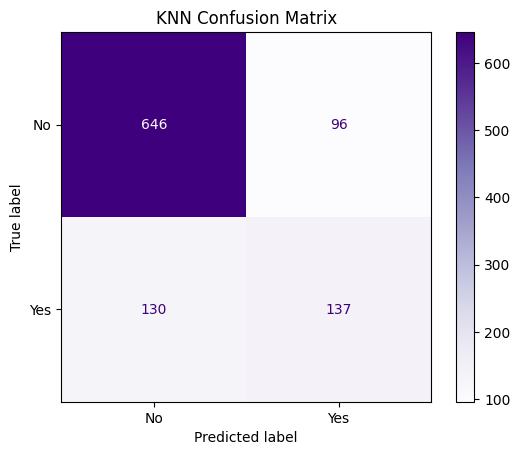

In [429]:
knn_cnf_matrix = confusion_matrix(y_eval_encoded, knn_y_pred)
disp = ConfusionMatrixDisplay(knn_cnf_matrix,display_labels=['No', 'Yes'])
disp.plot(cmap='Purples')
plt.title('KNN Confusion Matrix');

#### Support Vector Machine Pipeline

In [430]:
SVM_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', SVC(probability=True))
])

SVM_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', SVC(probability=True))])

In [431]:
svm_y_pred = SVM_pipeline.predict(X_eval)
svm_report = classification_report(y_eval_encoded, svm_y_pred)

# Define model predictions for the model and true labels
svm_pred_proba = SVM_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
svm_fpr, svm_tpr, _ = roc_curve(y_eval_encoded, svm_pred_proba)
# Calculate AUC for the model
svm_auc_score = auc(svm_fpr, svm_tpr)

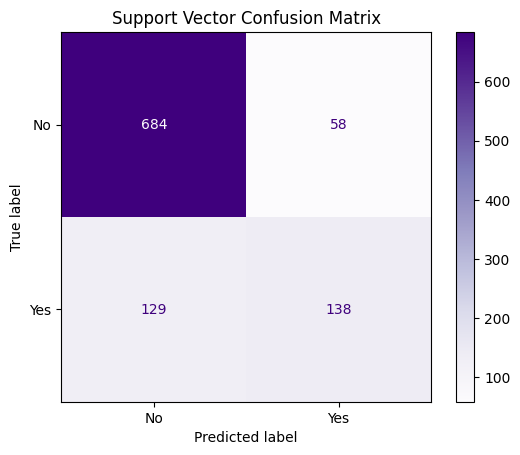

In [432]:
svm_cnf_matrix = confusion_matrix(y_eval_encoded, svm_y_pred)
disp = ConfusionMatrixDisplay(svm_cnf_matrix,display_labels=['No', 'Yes'])
disp.plot(cmap='Purples')
plt.title('Support Vector Confusion Matrix');

## Model Evaluation and Interpretation

### Classification Report

In [433]:
reports = [rfc_report, dtc_report, gbc_report, knn_report, svm_report]

for report in reports:
    if report == rfc_report:
        print('RandomForest Classification Report:\n', report)
        print('=====================================================')
    elif report == dtc_report:
        print('DecisionTree Classification Report:\n', report)
        print('=====================================================')
    elif report == gbc_report:
        print('GradientBoosting Classification Report:\n', report)
        print('=====================================================')
    elif report == knn_report:
        print('KNN Classification Report:\n', report)
        print('=====================================================')
    else:
        print('Support Vector Classification Report:\n', report)
        print('=====================================================')

RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       742
           1       0.68      0.49      0.57       267

    accuracy                           0.80      1009
   macro avg       0.75      0.70      0.72      1009
weighted avg       0.79      0.80      0.79      1009

DecisionTree Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       742
           1       0.52      0.51      0.51       267

    accuracy                           0.74      1009
   macro avg       0.67      0.67      0.67      1009
weighted avg       0.74      0.74      0.74      1009

GradientBoosting Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       742
           1       0.66      0.54      0.60       267

    accuracy                           0.81      1009
   macro avg 

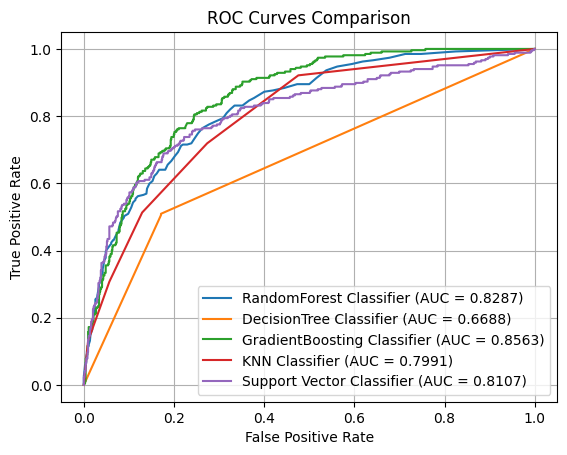

In [434]:
# Plot ROC curves
plt.plot(rfc_fpr, rfc_tpr, label=f'RandomForest Classifier (AUC = {rfc_auc_score:.4f})')
plt.plot(dtc_fpr, dtc_tpr, label=f'DecisionTree Classifier (AUC = {dtc_auc_score:.4f})')
plt.plot(gbc_fpr, gbc_tpr, label=f'GradientBoosting Classifier (AUC = {gbc_auc_score:.4f})')
plt.plot(knn_fpr, knn_tpr, label=f'KNN Classifier (AUC = {knn_auc_score:.4f})')
plt.plot(svm_fpr, svm_tpr, label=f'Support Vector Classifier (AUC = {svm_auc_score:.4f})')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### The AUC score gives us the rate of correct prediction for the model. The closer the rate is to 1.0, the better the perfomance of the model and when the rate is below 0.5 it implies the model is not the best.